# Quantum energy teleportation protocol with minimal model

The minimal model is the simplest model capable of doing energy teleportation, it's composed of a system of two qubits.

### Import packages

Import necessary packages to create and simulate the protocol.

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit_ibm_runtime import (QiskitRuntimeService, SamplerV2 as sampler, EstimatorV2 as estimator)
from qiskit.transpiler import preset_passmanagers
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

## Model

### Theory

In [3]:
# Define Parameters
h = 1; k = 3; 

# Basis of our states
ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0],[1]])
ket_00 = np.kron(ket_0,ket_0)
ket_11 = np.kron(ket_1,ket_1)

# Create Operators
I = Operator.from_label('II').to_matrix();
Z_A = Operator.from_label('IZ').to_matrix(); Z_B = Operator.from_label('ZI').to_matrix();
X_AB = Operator.from_label('XX').to_matrix(); X_A = Operator.from_label('IX').to_matrix();
Y_B = Operator.from_label('YI').to_matrix()

# Ground state
ket_g = np.sqrt(1/2)*np.sqrt(1-h/np.sqrt(h**2+k**2))*ket_00 - np.sqrt(1/2)*np.sqrt(1+h/np.sqrt(h**2+k**2))*ket_11
state_g = Statevector(ket_g)

# Hamiltonians
H_A = h*Z_A + h**2/np.sqrt(h**2+k**2) * I
H_B = h*Z_B + h**2/np.sqrt(h**2+k**2) * I
V = 2*k*X_AB + 2*k**2/np.sqrt(h**2+k**2) * I

# Define angle phi
phi = np.arctan2(h*k, h**2 + 2*k**2)/2

# Define operations
def P_0(mi):
    """Projective measurement on qubit 0 or A to measure mi"""
    return 1/2 * (I + mi*X_A)

def U_1(mi):
    """Conditional unitary operation dependent on mi"""
    return np.cos(phi) * I - 1j*mi*np.sin(phi) * Y_B

# Final State Density Matrix
P_QET = np.zeros((4, 4), dtype=complex)
for mi in [-1, 1]:
    P_QET = U_1(mi)@P_0(mi)@(ket_g@ket_g.conj().T)@P_0(mi)@U_1(mi).conj().T + P_QET

# Get energies from the final state
E_Ha = np.trace(P_QET@H_A).real
E_Hb = np.trace(P_QET@H_B).real
E_V = np.trace(P_QET@V).real
E_A = np.trace(P_QET@(H_A+V)).real
E_B = np.trace(P_QET@(H_B+V)).real # or -(h*k* np.sin(2*phi) - (h**2+2*k**2) * (1-np.cos(2*phi))) / np.sqrt(h**2 + k**2)

# Print results
display('Ground State:', state_g.draw('latex'))
display('Final State:', Operator(P_QET).draw('latex'))

print(f"""
Ground State Energies:
<H_A> = {ket_g.T@H_A@ket_g}
<H_B> = {ket_g.T@H_B@ket_g}
<V> = {ket_g.T@V@ket_g}
            
Final Energies:
H_A = {E_Ha},
H_B = {E_Hb},
V = {E_V},
E_A = {E_A},
E_B = {E_B}
""")

'Ground State:'

<IPython.core.display.Latex object>

'Final State:'

<IPython.core.display.Latex object>


Ground State Energies:
<H_A> = [[0.+0.j]]
<H_B> = [[0.+0.j]]
<V> = [[-7.77156117e-16+0.j]]
            
Final Energies:
H_A = 0.316227766016838,
H_B = 0.15182877871148076,
V = -0.22626375468978027,
E_A = 0.08996401132705767,
E_B = -0.07443497597829948



### Create circuit

In [41]:
def qet(h,k):

    # Generate circuit
    qc = QuantumCircuit(2)

    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,0)
    qc.cx(0,1)

    # Projective measurement on A*
    qc.barrier()
    qc.h(0)

    # Condicional operation on B
    qc.barrier()
    phi = np.arctan2(h*k,h**2+2*k**2)

    qc.cry(-phi,0,1)
    
    qc.x(0)
    qc.cry(phi,0,1)
    qc.x(0)

    return qc

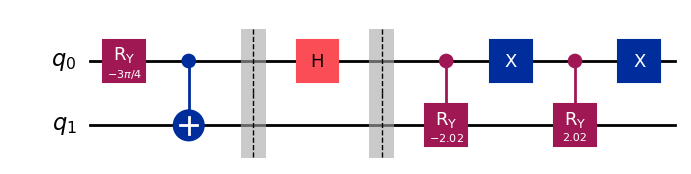

In [ ]:
# Show circuit
qet(1,1).draw('mpl')

## Simulate circuit

### Simulate circuits with aer simulator

Simulates the circuits without noise but with statistical randomness. 

In [42]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1; k = 1;
n_shots = 100000

# Generate circuits
qc_H = qet(h, k)
qc_H.measure_all()

qc_V = qet(h, k)
qc_V.h(1)
qc_V.measure_all()

# Run job with Sampler
sim_H = simulator.run([qc_H], shots=n_shots)
sim_V = simulator.run([qc_V], shots=n_shots)

### Show results for simulated circuit $H$

H_A = 0.705 ± 0.003
H_B = 0.255 ± 0.003


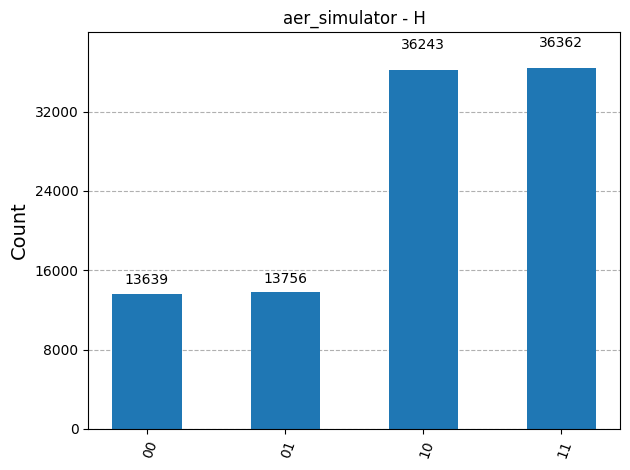

In [43]:
# Extract results
result = sim_H.result()
counts = result.get_counts()

# Energies constant term 
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Create error arrays
error_A = []
error_B = []

# Sum energies and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]                    # Invert bit ordering

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots     # Energy
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))        # Error
            error_B.append(h*(-1)**int(bit_string[1]))

# Calculate standart error 
std_A = np.std(error_A)/np.sqrt(n_shots)
std_B = np.std(error_B)/np.sqrt(n_shots)

# Show results
print(f"H_A = {ene_A:.3f} ± {std_A:.3f}")
print(f"H_B = {ene_B:.3f} ± {std_B:.3f}")

plot_histogram(counts, title="aer_simulator - H")

### Show results for simulated circuit V

V = -0.377 ± 0.006


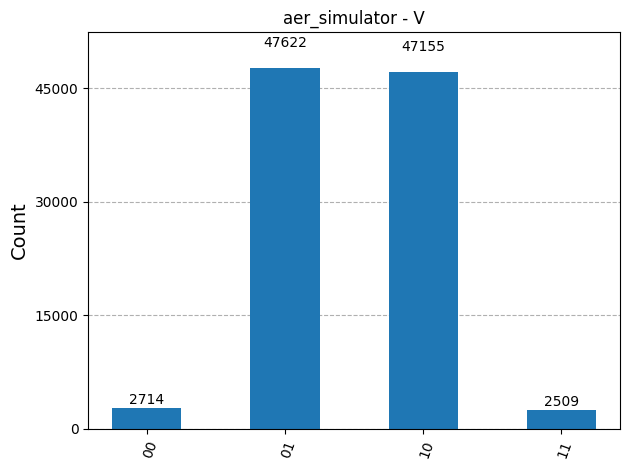

In [44]:
# Extract results
result = sim_V.result()
counts = result.get_counts()

# Energy constant term 
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Create Error arrays
error_V = []

# Sum energies and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]                                                      # Invert bit ordering

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots            # Energy

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))                                      # Error

# Calculate standart error
std_V = np.std(error_V)/np.sqrt(n_shots)

# Show results
print(f"V = {ene_V:.3f} ± {std_V:.3f}")

plot_histogram(counts, title='aer_simulator - V')

## Run circuit on hardware

### Get backend and its properties

Login the IBM Quantum Platform, selects the QPU with least number of jobs qeueded and shows some of its properties.

In [ ]:
# Log in IBM platform
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy()

# Show backend select
print(backend.name)

ibm_torino


### Run job with Sampler
Run job with Sampler Primitive

In [ ]:
# Parameters 
h = 1; k = 1
n_shots = 1500

# initiate sampler and configure error mitigation
sampler = sampler(mode=backend)

# Circuit H
circuit_H = qet(h,k)
circuit_H.measure_all()
transpiled_H = transpile(circuit_H, backend=backend, optimization_level=3)
# Run on backend
sampler_H = sampler.run([(transpiled_H)], shots=n_shots)
print(f"Sampler H, ID = {sampler_H.job_id()}, h = {h} k = {k}")

# Circuit V
circuit_V = qet(h,k)
circuit_V.h(1)
circuit_V.measure_all()
transpiled_V = transpile(circuit_V, backend=backend, optimization_level=3)
# Run on backend
sampler_V = sampler.run([(transpiled_V)], shots=n_shots)
print(f"Sampler V, ID = {sampler_V.job_id()}, h = {h} k = {k}")

Sampler H, ID = d1s6h6j250as73cjt490, h = 1 k = 3


### Run job with Estimator

Runs the appropriate circuit with the Estimator primitive.

In [ ]:
# Parameters
h = 1; k = 1

# Define observables
observables = [SparsePauliOp('ZI', h), SparsePauliOp('XX', 2*k)]

# Generate circuit
circuit_T = qet(h,k)
circuit_T.h(0)
transpiled_T = transpile(circuit_T, backend=backend, optimization_level=3)

# Run jobs
# Measure H_B
transpiled_observable = observables[0].apply_layout(transpiled_T.layout)
estimator_H = estimator().run([(transpiled_T, transpiled_observable)])
print(f"Estimator H, ID = {estimator_H.job_id()}, h = {h} k = {k}") 
# Measure V
transpiled_observable = observables[1].apply_layout(transpiled_T.layout)
estimator_V = estimator().run([(transpiled_T, transpiled_observable)]) 
print(f"Estimator V, ID = {estimator_V.job_id()}, h = {h} k = {k}") 


Estimator, ID = d1rv575s0e1s73bmnlf0, h = 1 k = 3
Estimator, ID = d1rv57o1mggs73b7c8h0, h = 1 k = 1.5


### Show results for circuit H

In [ ]:
# Extract results

# Sampler
jobS = service.job(sampler_H)
result = jobS.result()[0]
counts = result.data.meas.get_counts()

# Estimator
jobT = service.job(estimator_H)
result = jobT.result()[0]
exp_value = result.data.evs[0]
value_error = result.data.stds[0]

# parameters
h = 1; k = 1;
n_shots = 1500

# Energies constant term
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))
est_B = exp_value + ene_B

# Create error arrays
error_A = []
error_B = []

# Sum energies and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]                    # Invert bit ordering

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots     # Energy
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))        # Error
            error_B.append(h*(-1)**int(bit_string[1]))

# Show results
print(f"H_A = {ene_A:.3f} ± {np.std(error_A)/np.sqrt(n_shots):.3f}")
print(f"Sampler H_B = {ene_B:.3f} ± {np.std(error_B)/np.sqrt(n_shots):.3f}")
print(f"Estimator H_B = {est_B:.3f} ± {value_error:.3f}")

plot_histogram(counts, title=f"{jobS.backend().name} - H")

Sampler H_B = 0.1402277660168379 ± 0.025416844808118885
Estimator H_B = 0.17954239815569073 ± 0.03151827358245814


### Show results for circuit V

In [ ]:
# Extract results

# Sampler
jobS = service.job(sampler_V)
result = jobS.result()[0]
counts = result.data.meas.get_counts()

# Estimator
jobT = service.job(estimator_H)
result = jobT.result()[0]
exp_value = result.data.evs[0]
value_error = result.data.stds[0]

# Energy constant term
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))
est_V = exp_value + ene_V

# Create error arrays
error_V = []

# Sum energies and errors for each count
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]                                             # Invert bit ordering

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots   # Energy

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))                             # Error

# Show results
print(f"Sampler V = {ene_V:.3f} ± {np.std(error_V)/np.sqrt(n_shots):.3f}")
print(f"Estimated V = {est_V:.3f} ± {value_error:.3f}")

plot_histogram(counts, title=f"{jobS.backend().name} - V")

Sampler V = 0.316099788303082 ± 0.15462767324555243
Estimated V = -0.1402794059808219 ± 0.01076730876142635


## Extra: Initial ground state energy

Generate the ground state of the Minimal Model, simulate circuits to measure $H_A$, $H_B$ and $V$ and calculates $E_A$ and $E_B$

H_A = 0.001106781186547473 ± 0.0022395624572670433
H_B = 0.001106781186547473 ± 0.0022395624572670433
V = -0.0003464376269050884 ± 0.0063244990049805515
E_A = 0.0007603435596423846
E_B = 0.0007603435596423846


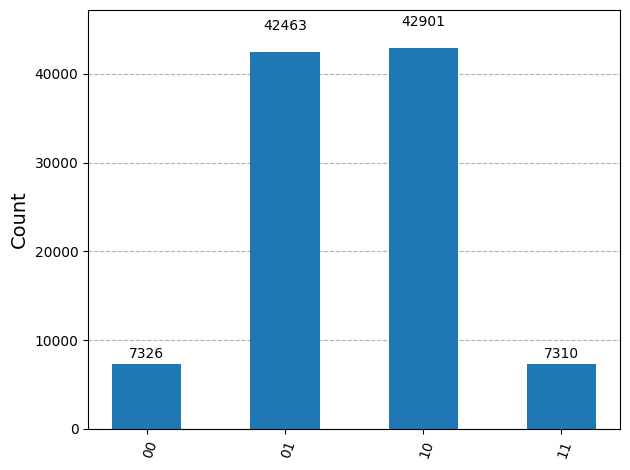

In [ ]:
from qiskit_aer.primitives import SamplerV2 as sampler

h = 1; k = 1;
theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

# Circuit V

qcV = QuantumCircuit(2)

# Prepare the ground state
qcV.ry(2*theta,0)
qcV.cx(0,1)

# Measure Energies
qcV.h(0)
qcV.h(1)
qcV.measure_all()

# Circuit H

qcH = QuantumCircuit(2)

# Prepare the ground state
qcH.ry(2*theta,0)
qcH.cx(0,1)

# Measure Energies
qcH.measure_all()

###################################################################################################################################################################################################

# Initiate simulator
simulator = AerSimulator()

# Parameters
n_shots = 100000

# Generate circuits
qcH = transpile(qcH, simulator, optimization_level=3)

qcV = transpile(qcV, simulator, optimization_level=3)

# Run job with Sampler
jobA = sampler().run([qcH], shots=n_shots)
jobB = sampler().run([qcV], shots=n_shots)

###################################################################################################################################################################################################
result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B = (h**2)/(np.sqrt(h**2+k**2))

# Error arrays
error_A = []
error_B = []

# Calculate errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_B += h*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

# Print results
print("H_A =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))


result = jobB.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

# Create error arrays
error_V = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

###################################################################################################################################################################################################
print("E_A =", ene_A + ene_V)
print("E_B =", ene_B + ene_V)

plot_histogram(counts)